In [17]:
# Traverses that are going to be extracted
extract_traverses = ["sunset1", "sunset2"]

# Read coordinates for selected traverses


In [18]:
from utils.gps_utils import get_gps
from constant_paths import event_paths, frame_paths, nmea_paths, video_beginning,video_paths
coordinates = {}

for traverse in extract_traverses:
    coordinates[traverse] = get_gps(nmea_paths[traverse])

In [19]:
import pandas as pd
import numpy as np

# Tolerance hyperparameters
space_tolerance = 1e-4
time_tolerance = 100

s1_gps = pd.DataFrame(coordinates[extract_traverses[0]])
s2_gps = pd.DataFrame(coordinates[extract_traverses[1]])

# Rename columns
s1_gps.columns = ["lat", "long", "time"]
s2_gps.columns = ["lat", "long", "time"]

# Add positional index
s1_gps = s1_gps.reset_index().rename(columns={'index': 'index_s1'})
s2_gps = s2_gps.reset_index().rename(columns={'index': 'index_s2'})

# Fusion of the two dataframe
merged_df = s1_gps.merge(s2_gps, how='cross')

# Filter the cross product within a certain tolerance (gps imprecision) and timing 
filtered_df = merged_df[
    (abs(merged_df['lat_x'] - merged_df['lat_y']) <= space_tolerance) &
    (abs(merged_df['long_x'] - merged_df['long_y']) <= space_tolerance) &
    (abs(merged_df['time_x'] - merged_df['time_y']) <= time_tolerance)
]

# Keep only positional indices
final_df = filtered_df[['index_s1', 'index_s2']].reset_index(drop=True)

# Remove duplicates (when the car is not moving) to match indices
final_df = final_df.drop_duplicates(subset=['index_s1'], keep='first')
final_df = final_df.drop_duplicates(subset=['index_s2'], keep='first')
final_df = final_df[['index_s1', 'index_s2']].reset_index(drop=True) # Reset dataframe indices

print(f"{len(final_df)} point(s) match spatio-temporal tolerances")

# Convert sampled points in numpy array for ease of use
sampled_points = {
    extract_traverses[0]: final_df['index_s1'].to_numpy(),
    extract_traverses[1]: final_df['index_s2'].to_numpy()
}

final_df.head()

547 point(s) match spatio-temporal tolerances


,index_s1,index_s2
0,3,0
1,4,1
2,5,2
3,6,3
4,7,4


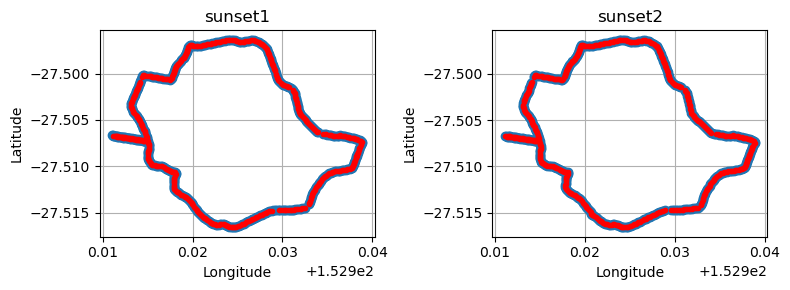

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
for index, traverse in enumerate(sampled_points):
    longitudes = coordinates[traverse].T[1]
    latitudes = coordinates[traverse].T[0]
    
    plt.subplot(1, 2,index+1)
    plt.plot(longitudes, latitudes, marker='o', linestyle='-')
    for point in sampled_points[traverse]:
        plt.plot(longitudes[point], latitudes[point], marker='.', color='r')
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.title(f"{traverse}")
plt.tight_layout()    

# Matching timestamps between frames and GPS 

In [21]:
import os
from os.path import join, basename
from os import listdir

def get_timestamp_matches(timestamps, timestamps_to_match):
    timestamps_matched = np.array([np.abs(timestamps - ts).argmin() for ts in timestamps_to_match])
    return timestamps_matched

timestamp_gps = {}
timestamp_frame = {}
timestamp_file_path = {}
matched_timestamp = {}

for traverse in extract_traverses:
    timestamp_gps[traverse] = [t + video_beginning[traverse] for t in coordinates[traverse][:,2]]
    timestamp_frame[traverse] = sorted([float(os.path.splitext(basename(f))[0]) for f in listdir(frame_paths[traverse]) if f.endswith('.png')])
    timestamp_file_path[traverse] = sorted([join(frame_paths[traverse], f) for f in listdir(frame_paths[traverse]) if f.endswith('.png')])
    matched_timestamp[traverse] = get_timestamp_matches(timestamp_frame[traverse], timestamp_gps[traverse])

1587452682.3548229
1587540364.6401856


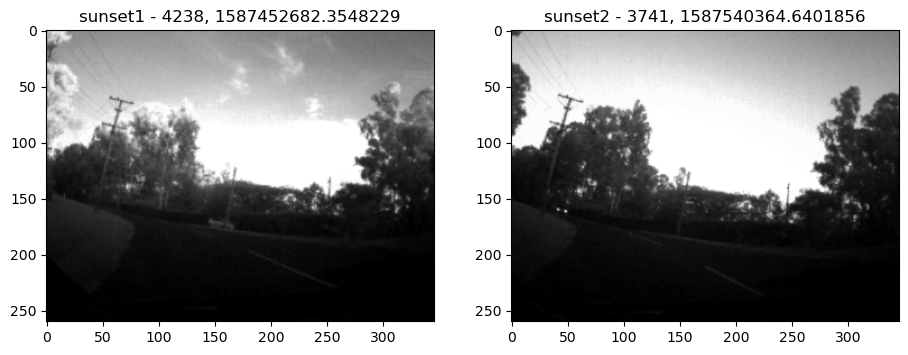

In [22]:
import pandas as pd
from PIL import Image

def getCorrelationValue(reference: np.array, comparison: np.array) -> float:
    reference = pd.DataFrame(reference.flatten())
    comparison = pd.DataFrame(comparison.flatten())
    result = reference.corrwith(comparison)
    return result[0]

def getTimestampFromFilePath(filepath):
    # Assuming the file path is from the timestampFilePath dictionnary
    return float(filepath.strip('.png\n').split("/")[-1])

# Get the calibrated timestamp for event data, (file name of the frame)
calibrated_timestamps = {}
for traverse in extract_traverses:
    calibrated_timestamps[traverse] = [(getTimestampFromFilePath(timestamp_file_path[traverse][image_index])) for image_index in matched_timestamp[traverse]]


frame_index = 80
plt.figure(figsize=(11,8))
for index, traverse in enumerate(extract_traverses):
    plt.subplot(1, 2, index+1)
    image_index = matched_timestamp[traverse][sampled_points[traverse][frame_index]] 
    frame = np.array(Image.open(timestamp_file_path[traverse][image_index]).convert('L'))

    print(calibrated_timestamps[traverse][frame_index])
    plt.title(f"{traverse} - {image_index}, {calibrated_timestamps[traverse][frame_index]}")
    plt.imshow(frame, cmap="gray")

Will use fixed size event windows with 100000 events
Output frame rate: variable
1224
547


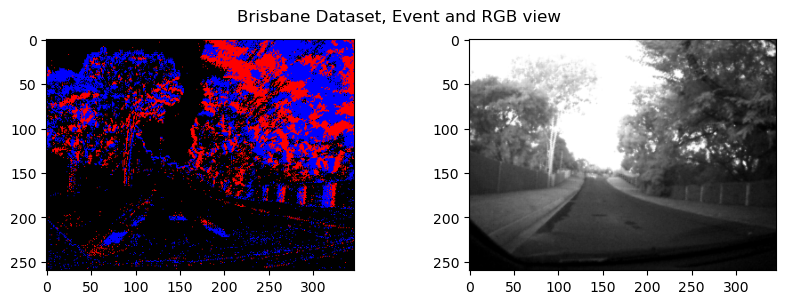

In [25]:
def convertListOfEventsIn2DVector(patternList, dimension=[260,346,2]):
    outVector = np.zeros((dimension[0], dimension[1], 3)) # 2 Channels, ON & OFF 
    for event in patternList:
        # Timestamp, X, Y, Polarity
        x = int(event[2])
        y = int(event[1])
        polarity = int(event[3])
        outVector[x][y][polarity] += 1
    return outVector

def addChannel(events):
    result = np.zeros((events.shape[0], events.shape[1], 3))
    result[:,:,0] = events[:,:,1] # Index 1 = ON on channel RED
    result[:,:,2] = events[:,:,0] # Index 0 = OFF on channel BLUE
    return result

def getVisualReprTimeWindow(events):   
    # Events should be dual channel array [W,H,2]
    maxChannel = np.argmax(events, axis=-1)
    maxValues = np.max(events, axis=-1)
    result = np.zeros_like(events)
    for x in range(events.shape[0]):
        for y in range(events.shape[1]):
            if maxValues[x][y] != 0:
                result[x][y][maxChannel[x][y]] = 1
    return addChannel(result)

def getTimestampFromFilePath(filepath):
    # Assuming the file path is from the timestampFilePath dictionnary
    return float(filepath.strip('.png\n').split("/")[-1])

calibrated_timestamps = {}
calibrated_file_paths = {}
# for traverse in extract_traverses:
#     #calibrated_file_paths[traverse] = [(timestamp_file_path[traverse][image_index]) for image_index in timestamp_file_path[traverse]]
#     calibrated_timestamps[traverse] = [(getTimestampFromFilePath(timestamp_file_path[traverse][image_index])) for image_index in matched_timestamp[traverse]]

# DUMB SHIT
for traverse in sampled_points:
    calibrated_timestamps[traverse] = []
for i in range((len(sampled_points[extract_traverses[0]]))):
    for index, traverse in enumerate(sampled_points):
        image_index = matched_timestamp[traverse][sampled_points[traverse][i]]
        calibrated_timestamps[traverse].append(getTimestampFromFilePath(timestamp_file_path[traverse][image_index]))

#########""""
from utils.event_readers import FixedSizeEventReader


frame_index = 20

traverse = "sunset1"
eventReader = FixedSizeEventReader(event_paths[traverse], num_events=100000)
image_index = matched_timestamp[traverse][sampled_points[traverse][frame_index]]

print(image_index)
print(len(calibrated_timestamps[traverse]))


eventPattern = next(eventReader)
while eventPattern[0][0] <  calibrated_timestamps[traverse][frame_index]:
    try:
        eventPattern = next(eventReader)
    except StopIteration:
        break

frame = np.array(Image.open(timestamp_file_path[traverse][image_index]).convert('L'))

plt.figure(figsize=(10,3))
plt.suptitle("Brisbane Dataset, Event and RGB view")
plt.subplot(1,2,1)
plt.imshow(getVisualReprTimeWindow(convertListOfEventsIn2DVector(eventPattern)))
plt.subplot(1,2,2)
plt.imshow(frame, cmap="gray")

np.save(f"calibrated_timestamps_events{extract_traverses[0]}_{extract_traverses[1]}.npy", calibrated_timestamps[extract_traverses[0]])
np.save(f"timestamp_file_path_events{extract_traverses[0]}_{extract_traverses[1]}.npy", timestamp_file_path[extract_traverses[0]])